<a href="https://colab.research.google.com/github/ahatesham02/Bangla-Image-Captioning/blob/main/Bangla_Image_Captioning_with_Bahdanau_Attention_(Bidirectional_GRU)_Bancap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!unzip -qq Flickr8k_Dataset.zip

In [ ]:
! pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import bnlp
from bnlp.corpus import  punctuations, letters, digits

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thesis/Flicker8k Bangla/BAN-Cap_captiondata.csv')

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head(15)

In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.bengali_caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

In [ ]:
table = str.maketrans('', '', punctuations)
desc = [w.translate(table) for w in data.bengali_caption]

In [ ]:
def cleaning(row):
  text = re.sub('[^\u0980-\u09FF]',' ', row) 
  return text

In [ ]:
data['bengali_caption'] = data.bengali_caption.apply(cleaning)

In [ ]:
data.head(10)

In [ ]:
clean_vocabulary = create_vocabulary(data)

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Flicker8k_Dataset'
images = listdir(image_dir)

In [ ]:
def clean(col):
  text = col.split('#')[0]
  return text
  
  

In [ ]:
data2 = data.copy()

In [ ]:
data2.head(10)

In [ ]:
data2['caption_id'] = data2.caption_id.apply(lambda x : x.split('#')[0])

In [ ]:
data2.head(10)

In [ ]:
data[7000:7010]

In [ ]:
data2.shape

In [ ]:
data3 = data2[:40000]

In [ ]:
data3.shape

In [ ]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in data3["caption_id"]:
      full_image_path = image_dir+"/"+ filenames
      img_name_vector.append(full_image_path)
  return img_name_vector
img_name_vector = preprocess_images(data)
img_name_vector[:10]

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data3["bengali_caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

In [ ]:
"""def data_limiter(num,total_captions,img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector"""

In [ ]:
#total_captions,img_name_vector = data_limiter(40000,total_captions,img_name_vector)

In [ ]:
len(total_captions)

In [ ]:
from pickle import dump

# save to file
dump(total_captions, open('bengali_captions.pkl', 'wb'))
dump(img_name_vector, open('bengali_img_names.pkl', 'wb'))

In [ ]:
from pickle import load

In [ ]:
total_captions = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_img_names.pkl', 'rb'))

In [ ]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [ ]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [ ]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the

In [ ]:
import tensorflow as tf

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [ ]:
image_model2 = ResNet50(include_top=False,weights='imagenet')
new_input = image_model2.input 
hidden_layer = image_model2.layers[-1].output  
image_features_extract_model2 = tf.compat.v1.keras.Model(new_input, hidden_layer)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [ ]:
for img in img_name_vector[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)


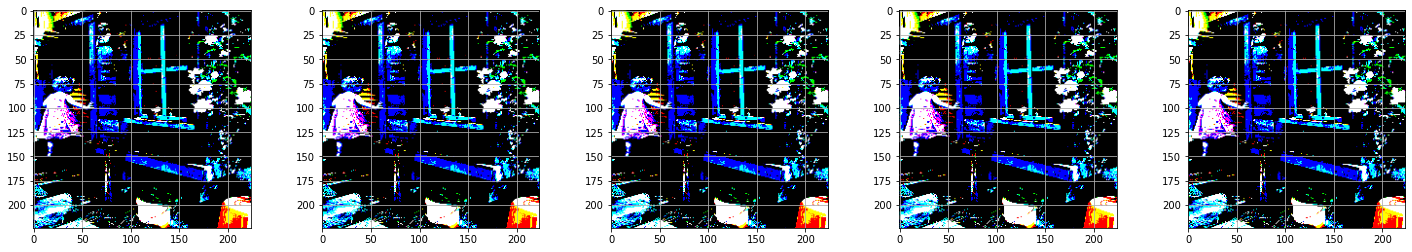

In [ ]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

Shape after resize : (224, 224, 3)


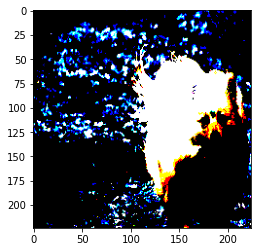

In [ ]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [ ]:
image_model2 = ResNet50(include_top=False,weights='imagenet')
new_input = image_model2.input 
hidden_layer = image_model2.layers[-1].output  
image_features_extract_model2 = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [ ]:
image_features_extract_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(total_captions)
train_seqs = tokenizer.texts_to_sequences(total_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(total_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
vocab_size = len(tokenizer.index_word)+1

In [ ]:
vocab_size

15539

In [ ]:
total_captions[:3]

['<start> একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে  <end>',
 '<start> একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে <end>',
 '<start> একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   <end>']

In [ ]:
train_seqs[:3]

[[2, 4, 181, 48, 22, 30, 42, 4, 1720, 1268, 851, 1122, 180, 140, 3],
 [2, 4, 42, 43, 4, 135, 7635, 3457, 3],
 [2, 4, 30, 19, 135, 3458, 140, 3]]

In [ ]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'একটি',
 5: 'একজন',
 6: 'কুকুর',
 7: 'আছে',
 8: 'এক',
 9: 'লোক',
 10: 'করছে',
 11: 'এবং',
 12: 'সাদা',
 13: 'কালো',
 14: 'উপর',
 15: 'মহিলা',
 16: 'বসে',
 17: 'খেলছে',
 18: 'দুটি',
 19: 'তার',
 20: 'রঙের',
 21: 'লাল',
 22: 'পরা',
 23: 'ছেলে',
 24: 'ছোট',
 25: 'দিয়ে',
 26: 'পরিহিত',
 27: 'ও',
 28: 'নীল',
 29: 'মধ্যে',
 30: 'বাচ্চা',
 31: 'দাঁড়িয়ে',
 32: 'পাশে',
 33: 'ব্যক্তি',
 34: 'করে',
 35: 'নিয়ে',
 36: 'লাফ',
 37: 'দিচ্ছে',
 38: 'দিকে',
 39: 'সামনে',
 40: 'দৌড়াচ্ছে',
 41: 'ধরে',
 42: 'মেয়ে',
 43: 'শিশু',
 44: 'যাচ্ছে',
 45: 'দাঁড়িয়ে',
 46: 'দিয়ে',
 47: 'থেকে',
 48: 'জামা',
 49: 'পরে',
 50: 'ঘাসের',
 51: 'কুকুরটি',
 52: 'বল',
 53: 'সাথে',
 54: 'নিয়ে',
 55: 'বাদামী',
 56: 'পানিতে',
 57: 'মেয়ে',
 58: 'কিছু',
 59: 'জন্য',
 60: 'সবুজ',
 61: 'হলুদ',
 62: 'একদল',
 63: 'মাঠে',
 64: 'পোশাক',
 65: 'দুই',
 66: 'মুখে',
 67: 'বালক',
 68: 'আছেন',
 69: 'দুজন',
 70: 'মানুষ',
 71: 'লোকটি',
 72: 'হাতে',
 73: 'সাইকেল',
 74: 'দেখছে',
 75: 'নারী',
 76: '

In [ ]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40000, 34)


In [ ]:
cap_vector

array([[  2,   4, 181, ...,   0,   0,   0],
       [  2,   4,  42, ...,   0,   0,   0],
       [  2,   4,  30, ...,   0,   0,   0],
       ...,
       [  2,  15,   4, ...,   0,   0,   0],
       [  2,   4, 196, ...,   0,   0,   0],
       [  2,  71,  77, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [ ]:
path_train, path_test, caption_train, caption_test = train_test_split(img_name_vector, cap_vector, test_size = 0.1, random_state = 42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 36000
Testing data for images: 4000
Training data for Captions: 36000
Testing data for Captions: 4000


In [ ]:
from tqdm import tqdm

In [ ]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model2(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


In [ ]:
batch_features.shape

TensorShape([64, 7, 7, 2048])

In [ ]:
img_features

{'/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg': array([[0.       , 0.       , 0.       , ..., 3.2088609, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 2.5231614, 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 6.8373137,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 3.8534899,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 4.3590326,
         0.       ]], dtype=float32),
 '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg': array([[0.        , 0.        , 0.        , ..., 0.61876726, 0.        ,
         0.        ],
        [1.4099259 , 0.        , 0.        , ..., 0.        , 5.197555  ,
         0.        ],
        [4.4140043 , 0.        , 0.512398  , ..., 0.        , 4.637447  ,
         0.        ],
        ...,
        [0.062014

In [ ]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [ ]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [ ]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 34)


In [ ]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE 
EPOCHS = 20
max_length = 34
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [ ]:
from keras.utils.vis_utils import plot_model

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [ ]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state= self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        print(output.shape)
        print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
class Decoder2(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder2, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state_f,state_b = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print(output.shape)
        #print(state_f.shape)
        #print(state_b.shape)
        state = tf.keras.layers.Add()([state_f, state_b])
        #print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
"""class Decoder2(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder2, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dense = tf.keras.layers.Dense(embed_dim)
        

    def call(self,x,features, hidden):
        context_vector1, attention_weights1 = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed1 = tf.concat([tf.expand_dims(context_vector1, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output1,state1= self.gru(embed1) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output1 = self.dense(output1)
        #state1 = self.dense(state1)
        context_vector2, attention_weights2 = self.attention(output1, state1)
        context_vector = tf.keras.layers.Add()([context_vector1, context_vector2])
        embed2 = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)
        output,state= self.gru(embed2)
        attention_weights = tf.keras.layers.Add()([attention_weights1, attention_weights2])
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))"""

In [ ]:
decoder=Decoder2(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 15539)
Attention weights shape from Decoder: (64, 49, 1)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/model_exp/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.451, & test loss is 1.252
Time taken for 1 epoch 301.7740099430084 sec

Test loss has been reduced from 100.000 to 1.252


  3%|▎         | 1/30 [05:02<2:26:19, 302.74s/it]

For epoch: 2, the train loss is 1.119, & test loss is 1.071
Time taken for 1 epoch 99.9205265045166 sec

Test loss has been reduced from 1.252 to 1.071


  7%|▋         | 2/30 [06:43<1:25:48, 183.88s/it]

For epoch: 3, the train loss is 0.988, & test loss is 0.951
Time taken for 1 epoch 101.33131337165833 sec

Test loss has been reduced from 1.071 to 0.951


 10%|█         | 3/30 [08:25<1:05:56, 146.52s/it]

For epoch: 4, the train loss is 0.887, & test loss is 0.857
Time taken for 1 epoch 101.89676117897034 sec

Test loss has been reduced from 0.951 to 0.857


 13%|█▎        | 4/30 [10:08<55:58, 129.19s/it]  

For epoch: 5, the train loss is 0.803, & test loss is 0.781
Time taken for 1 epoch 102.8823549747467 sec

Test loss has been reduced from 0.857 to 0.781


 17%|█▋        | 5/30 [11:51<49:59, 119.96s/it]

For epoch: 6, the train loss is 0.729, & test loss is 0.710
Time taken for 1 epoch 102.05319499969482 sec

Test loss has been reduced from 0.781 to 0.710


 20%|██        | 6/30 [13:34<45:39, 114.13s/it]

For epoch: 7, the train loss is 0.668, & test loss is 0.652
Time taken for 1 epoch 102.03664684295654 sec

Test loss has been reduced from 0.710 to 0.652


 23%|██▎       | 7/30 [15:17<42:19, 110.41s/it]

For epoch: 8, the train loss is 0.608, & test loss is 0.593
Time taken for 1 epoch 102.78952169418335 sec

Test loss has been reduced from 0.652 to 0.593


 27%|██▋       | 8/30 [17:00<39:41, 108.23s/it]

For epoch: 9, the train loss is 0.561, & test loss is 0.545
Time taken for 1 epoch 102.04121661186218 sec

Test loss has been reduced from 0.593 to 0.545


 30%|███       | 9/30 [18:43<37:17, 106.54s/it]

For epoch: 10, the train loss is 0.508, & test loss is 0.498
Time taken for 1 epoch 102.07931780815125 sec

Test loss has been reduced from 0.545 to 0.498


 33%|███▎      | 10/30 [20:26<35:07, 105.39s/it]

For epoch: 11, the train loss is 0.462, & test loss is 0.449
Time taken for 1 epoch 102.68963122367859 sec

Test loss has been reduced from 0.498 to 0.449


 37%|███▋      | 11/30 [22:09<33:11, 104.80s/it]

For epoch: 12, the train loss is 0.420, & test loss is 0.428
Time taken for 1 epoch 102.0380265712738 sec

Test loss has been reduced from 0.449 to 0.428


 40%|████      | 12/30 [23:52<31:15, 104.18s/it]

For epoch: 13, the train loss is 0.385, & test loss is 0.379
Time taken for 1 epoch 102.04949569702148 sec

Test loss has been reduced from 0.428 to 0.379


 43%|████▎     | 13/30 [25:35<29:24, 103.77s/it]

For epoch: 14, the train loss is 0.356, & test loss is 0.341
Time taken for 1 epoch 102.89226055145264 sec

Test loss has been reduced from 0.379 to 0.341


 47%|████▋     | 14/30 [27:19<27:39, 103.74s/it]

For epoch: 15, the train loss is 0.322, & test loss is 0.314
Time taken for 1 epoch 102.07008790969849 sec

Test loss has been reduced from 0.341 to 0.314


 50%|█████     | 15/30 [29:02<25:51, 103.46s/it]

For epoch: 16, the train loss is 0.298, & test loss is 0.289
Time taken for 1 epoch 101.98981976509094 sec

Test loss has been reduced from 0.314 to 0.289


 53%|█████▎    | 16/30 [30:44<24:05, 103.25s/it]

For epoch: 17, the train loss is 0.278, & test loss is 0.270
Time taken for 1 epoch 102.98624181747437 sec

Test loss has been reduced from 0.289 to 0.270


 57%|█████▋    | 17/30 [32:28<22:24, 103.41s/it]

For epoch: 18, the train loss is 0.256, & test loss is 0.251
Time taken for 1 epoch 102.01613903045654 sec

Test loss has been reduced from 0.270 to 0.251


 60%|██████    | 18/30 [34:11<20:38, 103.21s/it]

For epoch: 19, the train loss is 0.241, & test loss is 0.237
Time taken for 1 epoch 101.98810315132141 sec

Test loss has been reduced from 0.251 to 0.237


 63%|██████▎   | 19/30 [35:54<18:53, 103.08s/it]

For epoch: 20, the train loss is 0.227, & test loss is 0.222
Time taken for 1 epoch 102.85467529296875 sec

Test loss has been reduced from 0.237 to 0.222


 67%|██████▋   | 20/30 [37:37<17:12, 103.27s/it]

For epoch: 21, the train loss is 0.214, & test loss is 0.208
Time taken for 1 epoch 101.99889421463013 sec

Test loss has been reduced from 0.222 to 0.208


 70%|███████   | 21/30 [39:20<15:28, 103.13s/it]

For epoch: 22, the train loss is 0.202, & test loss is 0.196
Time taken for 1 epoch 101.97973418235779 sec

Test loss has been reduced from 0.208 to 0.196


 77%|███████▋  | 23/30 [42:45<12:00, 102.90s/it]

For epoch: 23, the train loss is 0.202, & test loss is 0.200
Time taken for 1 epoch 102.55042672157288 sec

For epoch: 24, the train loss is 0.194, & test loss is 0.182
Time taken for 1 epoch 101.99004626274109 sec

Test loss has been reduced from 0.196 to 0.182


 80%|████████  | 24/30 [44:29<10:18, 103.07s/it]

For epoch: 25, the train loss is 0.179, & test loss is 0.175
Time taken for 1 epoch 103.04727363586426 sec

Test loss has been reduced from 0.182 to 0.175


 87%|████████▋ | 26/30 [47:55<06:51, 102.91s/it]

For epoch: 26, the train loss is 0.187, & test loss is 0.180
Time taken for 1 epoch 101.98627877235413 sec

For epoch: 27, the train loss is 0.170, & test loss is 0.160
Time taken for 1 epoch 101.91190195083618 sec

Test loss has been reduced from 0.175 to 0.160


 90%|█████████ | 27/30 [49:37<05:08, 102.84s/it]

For epoch: 28, the train loss is 0.163, & test loss is 0.159
Time taken for 1 epoch 102.31266474723816 sec

Test loss has been reduced from 0.160 to 0.159


 93%|█████████▎| 28/30 [51:21<03:25, 102.91s/it]

For epoch: 29, the train loss is 0.158, & test loss is 0.153
Time taken for 1 epoch 101.87580728530884 sec

Test loss has been reduced from 0.159 to 0.153


 97%|█████████▋| 29/30 [53:03<01:42, 102.83s/it]

For epoch: 30, the train loss is 0.154, & test loss is 0.151
Time taken for 1 epoch 101.92276883125305 sec

Test loss has been reduced from 0.153 to 0.151


100%|██████████| 30/30 [54:46<00:00, 109.55s/it]


In [ ]:
ckpt_manager.checkpoints

['/content/model_exp/ckpt-24',
 '/content/model_exp/ckpt-25',
 '/content/model_exp/ckpt-26',
 '/content/model_exp/ckpt-27',
 '/content/model_exp/ckpt-28']

In [ ]:
ckpt.restore('/content/model_exp/ckpt-28')

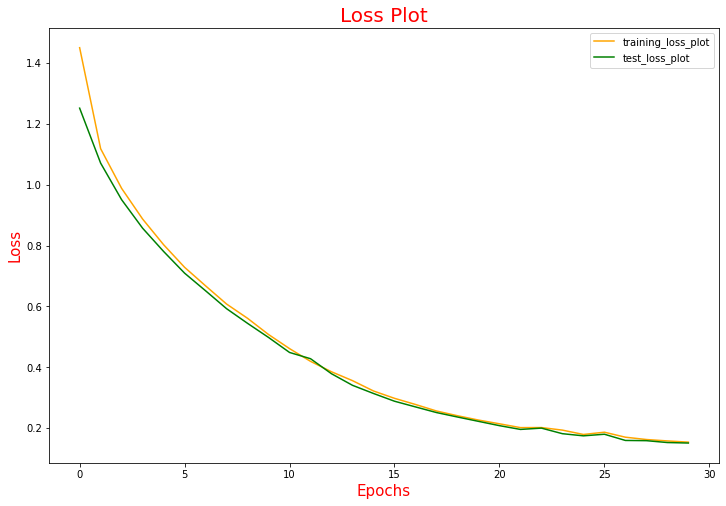

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model2(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (30, 30))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap])

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [ ]:
image_test = path_test.copy()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :
    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, len(path_test))
    test_image= path_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)
    #speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'bn', slow = False)
    #speech.save('voice.mp3')
    #audio_file = 'voice.mp3'
    #display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

BLEU score: 100.0
Real Caption: একলোক পাথর বাইছে
Prediction Caption: একলোক পাথর বাইছে


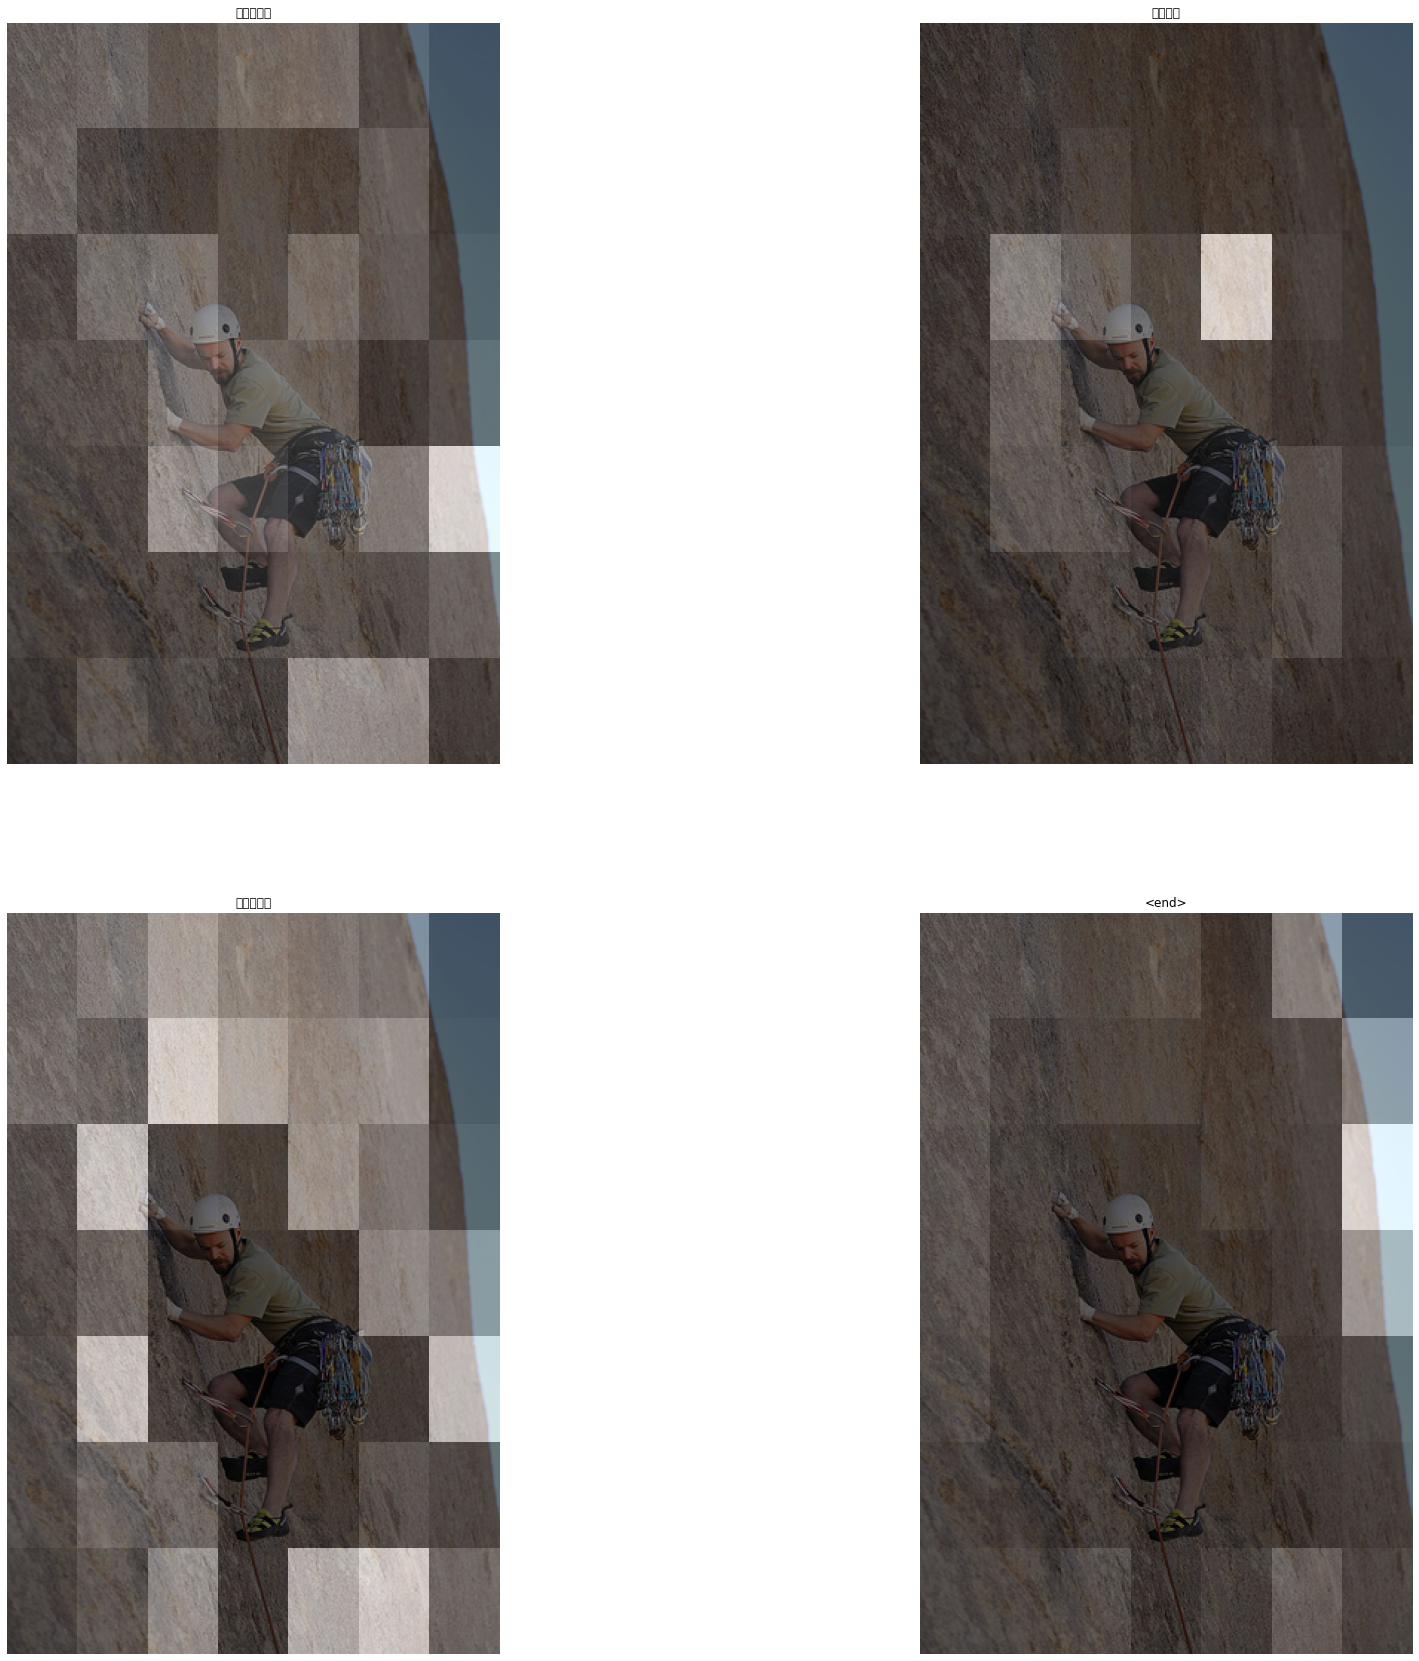

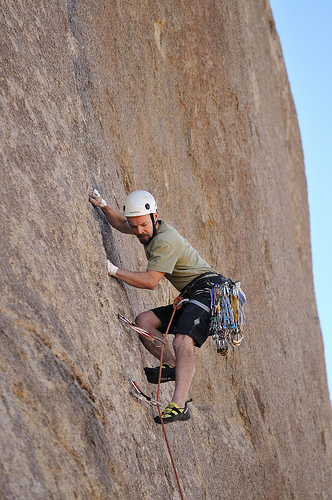

In [ ]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

BLEU-1: 29.205029
BLEU-2: 18.025735
BLEU-3: 8.544736
BLEU-4: 6.138966
Real Caption: তিনজন তরুণ কালো যুবক সাদা ঝিপটির সঙ্গে হেলান দিয়ে আছে
Prediction Caption: তিনজন তরুণ একটি টয়োটা ট্রাকের পাশে দাড়িয়ে আছে


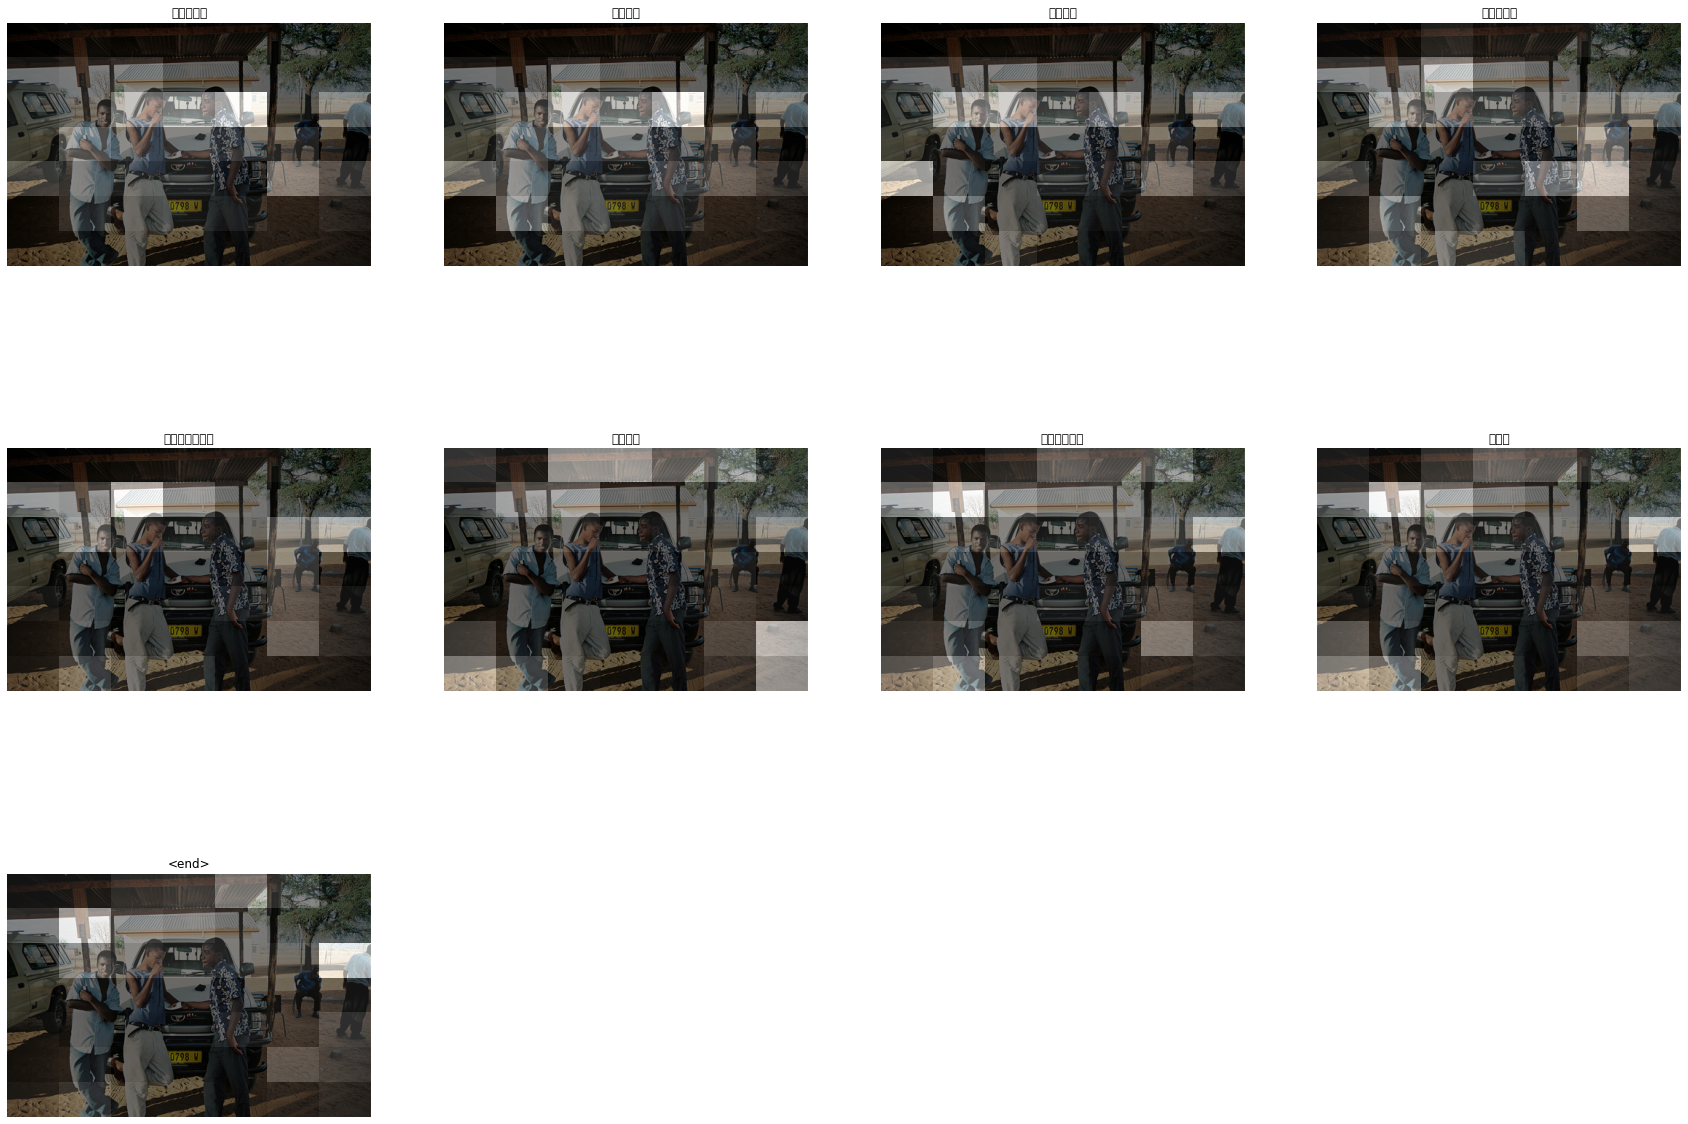

In [ ]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.translate.meteor_score import meteor_score

In [ ]:
b1=[]
b2=[]
b3=[]
b4=[]
m_score = []

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

In [ ]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

BLEU-1: 69.259858
BLEU-2: 66.378019
BLEU-3: 64.062129
BLEU-4: 62.471025


In [ ]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

Meteor Score of Bahdanau attention: 0.702276
